In [36]:
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
from numba import jit, njit, int64, float64, boolean
import numba as nb
from numba_i0_i1 import i0, i1
# from numbalsoda import lsoda_sig, lsoda 

from handle_collisions import handle_collisions

import matplotlib.pyplot as plt
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=18)


from joblib import Parallel, delayed
e = 1.602e-19
eps0 = 8.8541878128e-12
u = 1.66e-27
k_B = 1.381e-23 # J/K
Omega = 2*np.pi*305e3

In [37]:
import sys
# sys.path.append('C:\\Users\\au643642\\OneDrive - Aarhus universitet\\Dokumenter\\PhD\\LUNA2 Mass selection tool')
# from mass_selection_functions import popt_all_fit
# xi1, xi0, upper_edge_shrink1, upper_edge_shrink0, lower_edge_shrink1, lower_edge_shrink0 = popt_all_fit[:6]
# from mathieu_functions import upper_mathieu_variable_shrink, lower_mathieu_variable_shrink

def get_z0(r0, mz):
    xi = (xi1*mz + xi0)
    return np.sqrt((xi-r0**2)/2)

def QIT_diagram(RF_V, upper, mz, QIT_r0, QIT_z0):
    xi = (QIT_r0**2 + 2*QIT_z0**2)
    q_to_V = mz*u/e*Omega**2/8 * xi
    if upper:
        return upper_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V
    return lower_mathieu_variable_shrink(np.atleast_1d(RF_V) / q_to_V, 0, 0, 0, 0)*q_to_V

In [38]:
@njit(nb.types.Tuple((float64[:], float64[:]))(float64, float64, float64))
def find_I0_lns(r0, z0, max_order):
    i = np.arange(max_order+1)
    ln = (2*i+1)*np.pi/2/z0
    res = i0(r0*ln)
    return res, ln
@njit(nb.types.Tuple((float64[:], float64[:]))(float64[:], float64[:], float64[:], float64[:]))
def optimized_besselsum(zs, rs, I0_lns, ln):
    cos_term = np.cos(np.outer(ln, zs))  # Precompute the cos term matrix
    sin_term = np.sin(np.outer(ln, zs))  # Precompute the sin term matrix
    r_ln_matrix = np.outer(ln, rs)
    i0_r_ln_matrix = i0(r_ln_matrix.flatten())
    i1_r_ln_matrix = i1(r_ln_matrix.flatten())
    i0_r_ln_matrix = i0_r_ln_matrix.reshape(r_ln_matrix.shape)
    i1_r_ln_matrix = i1_r_ln_matrix.reshape(r_ln_matrix.shape)
    
    bessel_r_matrix = (-1) ** np.arange(len(ln))[:, np.newaxis]       * i1_r_ln_matrix / I0_lns[:, np.newaxis]
    bessel_z_matrix = (-1) ** (np.arange(len(ln)) + 1)[:, np.newaxis] * i0_r_ln_matrix / I0_lns[:, np.newaxis]
    
    besselsum_r = np.sum(bessel_r_matrix * cos_term, axis=0)
    besselsum_z = np.sum(bessel_z_matrix * sin_term, axis=0)
    
    return besselsum_r, besselsum_z

@njit(float64[:](float64,
     float64[:],
     int64,
     int64,
     int64,
     float64,
     float64,
     float64,
     float64,
     float64[:],
     float64[:],
     int64,
     boolean[:]))
def CIT_EOM_cartesian(t, y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, N_sim, is_not_out_of_bounds):
    q = charge_number*e

    xs = y[:N_sim]
    ys = y[N_sim:2*N_sim]
    rs = np.sqrt(xs**2 + ys**2)

    zs = y[2*N_sim:3*N_sim]
    
    vxs = y[3*N_sim:4*N_sim]
    vys = y[4*N_sim:5*N_sim]
    vzs = y[5*N_sim:]
    

    besselsum_r, besselsum_z = optimized_besselsum(zs, rs, I0_lns, ln)
    t_factor = -2*q/mass/z0 * (U + V*np.cos(Omega*t))

    acc_r = besselsum_r * t_factor
    acc_z = besselsum_z * t_factor

    ret = np.empty_like(y)
    ret[       :  N_sim] = is_not_out_of_bounds * vxs
    ret[  N_sim:2*N_sim] = is_not_out_of_bounds * vys
    ret[2*N_sim:3*N_sim] = is_not_out_of_bounds * vzs

    ret[3*N_sim:4*N_sim] = is_not_out_of_bounds * acc_r * xs / rs
    ret[4*N_sim:5*N_sim] = is_not_out_of_bounds * acc_r * ys / rs
    ret[5*N_sim:       ] = is_not_out_of_bounds * acc_z
    return ret

# @cfunc(lsoda_sig)
# def CIT_EOM_cartesian_numbalsoda(t, y, dy, p):
#     U = p[0]
#     V = p[1]
#     charge_number = p[2]
#     mass = p[3]
#     r0 = p[4]
#     z0 = p[5]
#     Omega = p[6]
#     N_sim = p[7]
#     N_order = p[8]
#     I0_lns = p[9:9 + N_order+1]
#     I0_lns = nb.carray(I0_lns, N_order+1)
#     ln = p[9 + N_order+1:9 + N_order+1 + N_order+1]
#     ln = nb.carray(ln, N_order+1)
#     is_not_out_of_bounds = p[9 + N_order+1+N_order+1 : 9 + N_order+1+N_order+1 + N_sim]
#     is_not_out_of_bounds = nb.carray(is_not_out_of_bounds, N_sim)

#     q = charge_number*e

#     xs = nb.carray(y[:N_sim], N_sim)
#     ys = nb.carray(y[N_sim:2*N_sim], N_sim)
#     rs = np.sqrt(xs**2 + ys**2)

#     zs = nb.carray(y[2*N_sim:3*N_sim], N_sim)
    
#     vxs = nb.carray(y[3*N_sim:4*N_sim], N_sim)
#     vys = nb.carray(y[4*N_sim:5*N_sim], N_sim)
#     vzs = nb.carray(y[5*N_sim:], N_sim)
    

#     besselsum_r, besselsum_z = optimized_besselsum(zs, rs, I0_lns, ln)
#     t_factor = -2*q/mass/z0 * (U + V*np.cos(Omega*t))

#     acc_r = besselsum_r * t_factor
#     acc_z = besselsum_z * t_factor

#     dy[       :  N_sim] = is_not_out_of_bounds * vxs
#     dy[  N_sim:2*N_sim] = is_not_out_of_bounds * vys
#     dy[2*N_sim:3*N_sim] = is_not_out_of_bounds * vzs

#     dy[3*N_sim:4*N_sim] = is_not_out_of_bounds * acc_r * xs / rs
#     dy[4*N_sim:5*N_sim] = is_not_out_of_bounds * acc_r * ys / rs
#     dy[5*N_sim:       ] = is_not_out_of_bounds * acc_z

In [39]:
# I0_lns, ln = find_I0_lns(10e-3, 9e-3, 10)
# rs = np.random.normal(0, 1e-3, 100)  # Larger vector
# zs = np.random.normal(0, 1e-3, 100)  # Larger vector
# optimized_besselsum(zs, rs, I0_lns, ln)

In [40]:
@njit
def simulate_CIT_with_buffer_gas(U : float, V : float, r0 : float, z0 : float, Omega : float,
                                 mass_amu : int, charge_number : int, N_sim : int, sigma_xyz : float,
                                 T : float, ts, buffer_gas_p_mbar = 0.1):
    mass = mass_amu * u
    mass_gas = 4 * u
    reduced_mass = mass*mass_gas/(mass + mass_gas)
    
    buffer_gas_n_density = 7.23e21 * buffer_gas_p_mbar/0.1 / 3 # n/V = p/RT @ 100K -->300K modification by division of 3, 0.1 mbar
    cross_section_ion_buffer_gas = 2.3e-18*10

    N_order = 10
    I0_lns, ln = find_I0_lns(r0, z0, N_order)
    
    MB_sigma = np.sqrt(k_B*T / mass)
    y0s = np.empty(6*N_sim)
    for i in range(3*N_sim):
        y0s[i]         = np.random.normal(0, sigma_xyz)
        y0s[3*N_sim+i] = np.random.normal(0, MB_sigma)

    y0s[:3*N_sim] = np.clip(y0s[:3*N_sim], -0.8*r0, 0.8*r0)
    y0s[3*N_sim:] = np.clip(y0s[3*N_sim:], -3*MB_sigma, 3*MB_sigma)

    curr_y = y0s
    
    xs = curr_y[:N_sim]
    ys = curr_y[N_sim:2*N_sim]
    zs = curr_y[2*N_sim:3*N_sim]
    vxs = curr_y[3*N_sim:4*N_sim]
    vys = curr_y[4*N_sim:5*N_sim]
    vzs = curr_y[5*N_sim:]
    rs = np.sqrt(xs**2+ys**2)
    axs = np.zeros(N_sim)
    ays = np.zeros(N_sim)
    azs = np.zeros(N_sim)

    out_of_bounds = np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0)
    not_out_of_bounds = np.logical_not(out_of_bounds)
    curr_N = N_sim
    
    n_steps = len(ts)-1
    N_history = np.empty(n_steps+1)
    n_collisions_history = np.empty(n_steps)
    vs_mean_history = np.empty((n_steps, 3))#[np.array([np.mean(vxs), np.mean(vys), np.mean(vzs)])]
    vs_std_history  = np.empty((n_steps, 3))#[np.array([np.std(vxs), np.std(vys), np.std(vzs)])]
    
    N_history[0] = N_sim
    
    
    
    masterR = np.zeros((n_steps+1,N_sim))


    masterZ = np.zeros((n_steps+1,N_sim))
    for ion in range(N_sim):
        masterZ[0,ion] = zs[ion]
        masterR[0,ion] = rs[ion]
    
    for i in range(n_steps):
        t_start = ts[i]
        t_end = ts[i+1]
        t_step = t_end - t_start

        ## -- Trying numbaLSODA
        # p = np.empty(11 + 2*N_order + N_sim)
        # p[0] = U
        # p[1] = V
        # p[2] = charge_number
        # p[3] = mass
        # p[4] = r0
        # p[5] = z0
        # p[6] = Omega
        # p[7] = N_sim
        # p[8] = N_order
        # p[9:9 + N_order+1] = I0_lns
        # p[9 + N_order+1:9 + N_order+1 + N_order+1] = ln
        # p[9 + N_order+1+N_order+1 : 9 + N_order+1+N_order+1 + N_sim] = not_out_of_bounds
        # usol, success = lsoda(CIT_EOM_cartesian_numbalsoda, np.linspace(t_start, t_end, 3), u0=curr_y, data=p)
        # curr_y = usol[-1]
        ## - END NUMBA-LSODA

        ## -- Velocity-Verlet
        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]
        vxs = curr_y[3*N_sim:4*N_sim]
        vys = curr_y[4*N_sim:5*N_sim]
        vzs = curr_y[5*N_sim:]

        # Update positions
        xs += vxs*t_step + 0.5*axs*t_step**2
        ys += vys*t_step + 0.5*ays*t_step**2
        zs += vzs*t_step + 0.5*azs*t_step**2

        # Calculate the acceleration
        dy = CIT_EOM_cartesian(t_start, curr_y, U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, N_sim, not_out_of_bounds)

        # Update velocities
        curr_y[3*N_sim:4*N_sim] += 0.5 * (axs + dy[3*N_sim:4*N_sim]) * t_step
        curr_y[4*N_sim:5*N_sim] += 0.5 * (ays + dy[4*N_sim:5*N_sim]) * t_step
        curr_y[5*N_sim:]        += 0.5 * (azs + dy[5*N_sim:]       ) * t_step

        # Update accelerations
        axs = dy[3*N_sim:4*N_sim]
        ays = dy[4*N_sim:5*N_sim]
        azs = dy[5*N_sim:]
        ## - END VELOCITY-VERLET

        ## -- SOLVE IVP
        # sol = solve_ivp(CIT_EOM_cartesian, [t_start, t_end], y0=curr_y,
        #                 args=(U, V, charge_number, mass, r0, z0, Omega, I0_lns, ln, N_sim, not_out_of_bounds))
        
        # curr_y = sol.y[:,-1]
        ## -- END SOLVE IVP

        xs = curr_y[:N_sim]
        ys = curr_y[N_sim:2*N_sim]
        zs = curr_y[2*N_sim:3*N_sim]
        vxs = curr_y[3*N_sim:4*N_sim]
        vys = curr_y[4*N_sim:5*N_sim]
        vzs = curr_y[5*N_sim:]

        # Check if some of the simulation ions are out of bounds
        out_of_bounds     = np.logical_or(out_of_bounds, np.logical_or(np.abs(zs) > z0, np.sqrt(xs**2 + ys**2) > r0))
        not_out_of_bounds = np.logical_not(out_of_bounds)

        curr_N = np.sum(not_out_of_bounds)
        N_history[i+1] = curr_N
        if curr_N == 0:
            break
        rs = np.sqrt(xs**2+ys**2)
        for ion in range(N_sim):
            masterZ[i+1,ion] = zs[ion]
            masterR[i+1,ion] = rs[ion]
        
        vs_mean_history[i] = np.array([np.mean(vxs[not_out_of_bounds]), np.mean(vys[not_out_of_bounds]), np.mean(vzs[not_out_of_bounds])])
        vs_std_history[i]  = np.array([np.std(vxs[not_out_of_bounds]), np.std(vys[not_out_of_bounds]), np.std(vzs[not_out_of_bounds])])
        

        ## Handle collisions - update velocities
        ## Calculate probability of collision - Ding 2002
        delta_vxs, delta_vys, delta_vzs, n_collisions = handle_collisions(vxs, vys, vzs, N_sim, t_step, not_out_of_bounds, T, mass, 
                                                                          mass_gas, reduced_mass, buffer_gas_n_density, cross_section_ion_buffer_gas)
        
        # n_collisions_history.append(n_collisions)
        vxs += delta_vxs
        vys += delta_vys
        vzs += delta_vzs

        # print('Progress: {:2.2f}%'.format((i + 1)/len(ts) * 100), end='\r')
    return curr_N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history, masterR, masterZ

In [41]:
mass = 443
charge_number = 1
N_sim = 100

delta_t = 1e-3
ts = np.arange(0, delta_t, 5e-8)
r0 = 10e-3
z0 = 9e-3
sigma_xyz = 6e-3
T = 300

N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history,masterR, masterZ\
   = simulate_CIT_with_buffer_gas(U=0, V=420, r0=r0, z0=z0, Omega = Omega,
                                    mass_amu=mass, charge_number=charge_number, 
                                    N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                    ts=ts)

In [25]:
xs = curr_y[:N_sim][not_out_of_bounds]
ys = curr_y[N_sim:2*N_sim][not_out_of_bounds]
rs = np.sqrt(xs**2 + ys**2)
zs = curr_y[2*N_sim:3*N_sim][not_out_of_bounds]
np.std(rs)*1e3, np.std(zs)*1e3


(0.22284541859951473, 0.10018706616874774)

(0.0, 100.0)

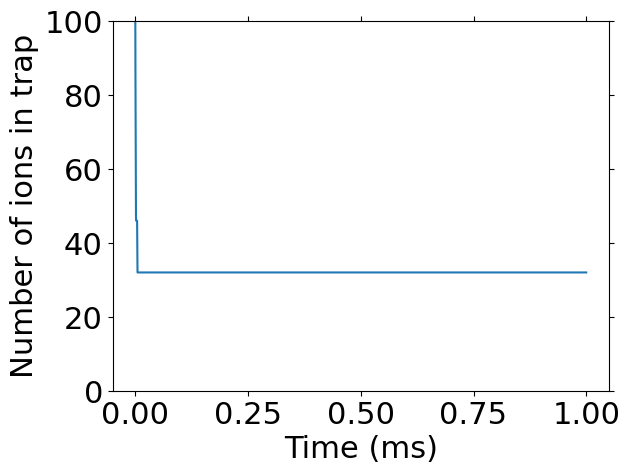

In [27]:
plt.plot(ts*1e3, N_history)
plt.xlabel('Time (ms)')
plt.ylabel('Number of ions in trap')
plt.ylim(0,100)

(0.0, 110.00000000000001)

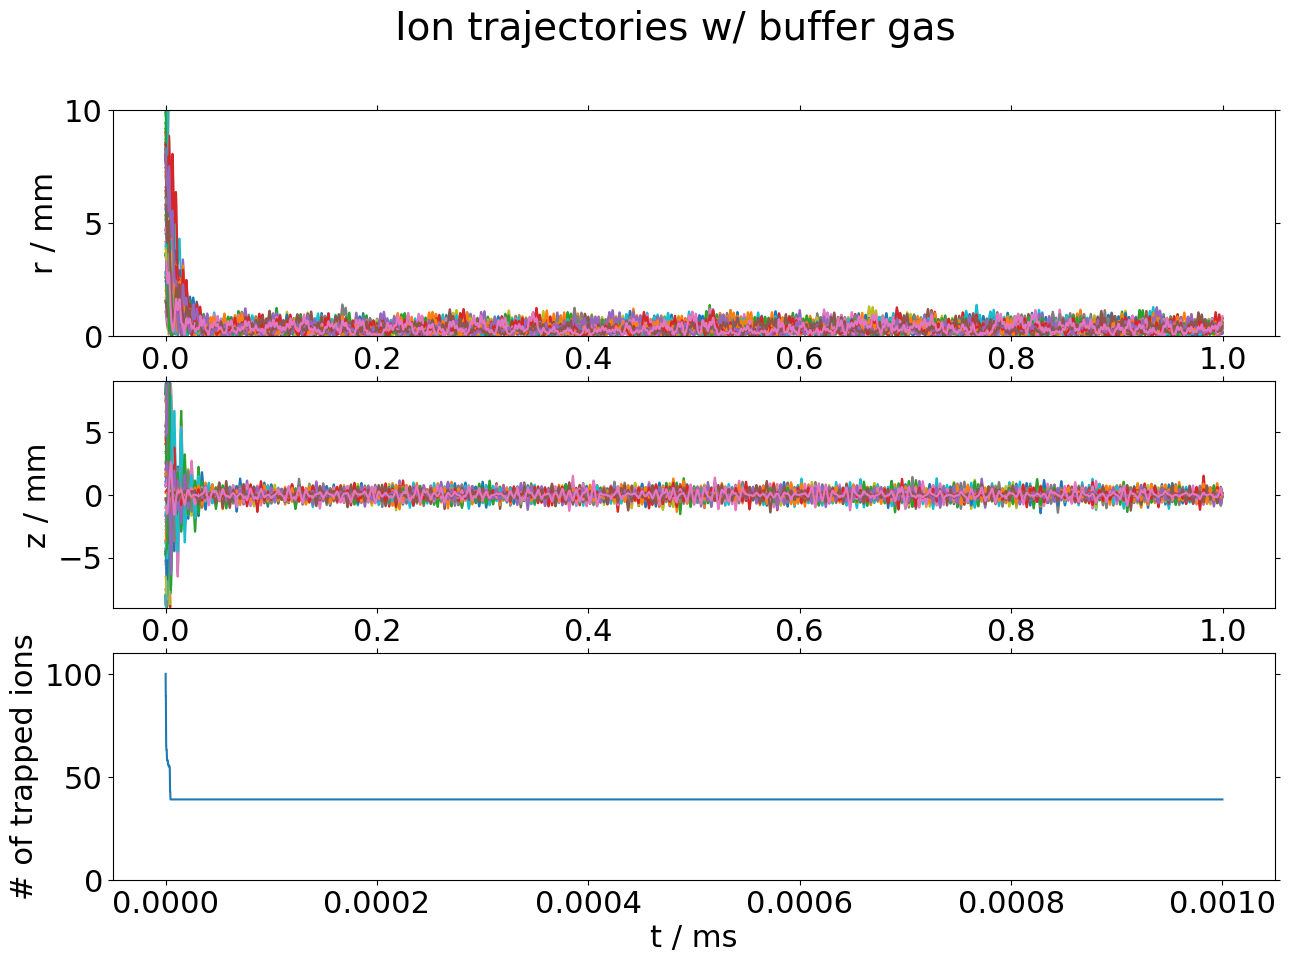

In [42]:
fig,ax = plt.subplots(3,1,figsize = (15,10))
# ax[0].plot(ts,np.array(masterR)*1e3)
# ax[1].plot(ts,np.array(masterZ)*1e3)

for column_nr in range(masterR.shape[1]):
    Rs = masterR[:,column_nr]
    Zs = masterZ[:,column_nr]
    breakpointZ = len(ts)-1
    breakpointR = len(ts)-1
    for j,z in enumerate(Zs):
        if (np.abs(z)>= z0) or (np.isnan(z)):
            breakpointZ = j
            break
    for j,r in enumerate(Rs):
        if (r>= r0) or (np.isnan(r)):
            breakpointR = j
            break
    breakpoint = np.min([breakpointR,breakpointZ])            
    ax[0].plot(ts[:breakpoint]*1e3,Rs[:breakpoint]*1e3)
    ax[1].plot(ts[:breakpoint]*1e3,Zs[:breakpoint]*1e3)

ax[0].set_ylim(0,(r0)*1e3)
ax[1].set_ylim(-z0*1e3,z0*1e3)
ax[2].set_xlabel('t / ms')
ax[0].set_ylabel('r / mm')
ax[1].set_ylabel('z / mm')
ax[2].set_ylabel('# of trapped ions')
ax[2].plot(ts,N_history)
fig.suptitle('Ion trajectories w/ buffer gas',fontsize = 28)
ax[2].set_ylim(0,N_sim*1.1)

In [48]:
VDCs = np.linspace(-50,120,100)
VRFs = np.linspace(250,500,100)

In [49]:
def get_stability(RF):
    mass = 443
    charge_number = 1
    N_sim = 100

    delta_t = 1e-3
    ts = np.arange(0, delta_t, 5e-8)
    r0 = 10e-3
    z0 = 9e-3
    sigma_xyz = 6e-3
    T = 300
    N_arr = []
    for DC in VDCs:
        N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history,masterR, masterZ\
        = simulate_CIT_with_buffer_gas(U=DC, V=RF, r0=r0, z0=z0, Omega = Omega,
                                    mass_amu=mass, charge_number=charge_number, 
                                    N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                    ts=ts)
        N_arr.append(N)
    return N_arr
U_edge_long_sim = Parallel(n_jobs=14, verbose=12)(delayed(get_stability)(RF) for RF in VRFs)

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=14)]: Done   2 tasks      | elapsed:  2.8min
[Parallel(n_jobs=14)]: Done   3 tasks      | elapsed:  2.9min
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:  2.9min
[Parallel(n_jobs=14)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=14)]: Done   6 tasks      | elapsed:  3.1min
[Parallel(n_jobs=14)]: Done   7 tasks      | elapsed:  3.1min
[Parallel(n_jobs=14)]: Done   8 tasks      | elapsed:  3.2min
[Parallel(n_jobs=14)]: Done   9 tasks      | elapsed:  3.2min
[Parallel(n_jobs=14)]: Done  10 tasks      | elapsed:  3.2min
[Parallel(n_jobs=14)]: Done  11 tasks      | elapsed:  3.3min
[Parallel(n_jobs=14)]: Done  12 tasks      | elapsed:  3.4min
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:  3.4min
[Parallel(n_jobs=14)]: Done  14 tasks      | elapsed:  3.5min
[Parallel(n_jobs=14)]: Done  15 tasks      | elapsed:  

In [50]:
# print(U_edge_long_sim)
DATA = np.array(U_edge_long_sim[1])
for line in U_edge_long_sim[1:]:
    DATA = np.vstack((DATA,np.array(line)))
    # print()
print(DATA.T.shape)

(100, 100)


(100,) (100,)


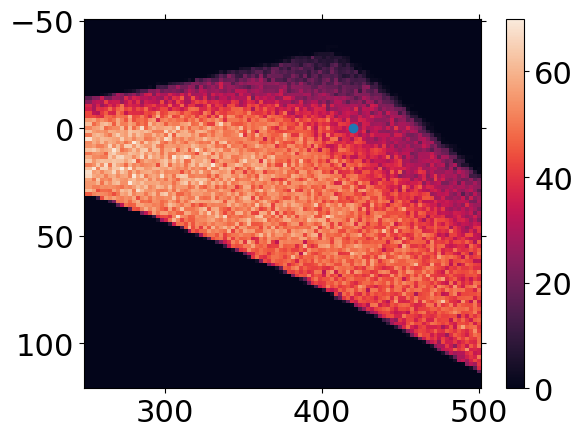

In [51]:
fig,ax = plt.subplots()
print(VDCs.shape,VRFs.shape)
# DATA = np.loadtxt(r'C:\Users\lenle\Documents\PhD-Work\Lab Stuff\ESI\Thomas Simulations\DATA_w_buffer_fine_100_x_100.txt')

heatmap = ax.pcolormesh(VRFs,VDCs,DATA.T, cmap = 'rocket')
fig.colorbar(heatmap)
ax.invert_yaxis()
ax.scatter(420,0)

In [52]:
np.savetxt("DATA_w_buffer_fine_100_x_100_6mm.txt",DATA)
np.savetxt("VRF_w_buffer_fine_100_x_100_6mm.txt",VRFs)
np.savetxt("VDC_w_buffer_fine_100_x_100_6mm.txt",VDCs)

In [42]:
def simulate_signal(V, r0, z0, Omega, mass, charge_number, N_sim, ts):
    xi = np.sqrt(2.357e-4)
    edge_upper = QIT_diagram(V, True,  mass, QIT_r0=xi, QIT_z0=0)[0]
    edge_lower = QIT_diagram(V, False, mass, QIT_r0=xi, QIT_z0=0)[0]
    delta_U_V = 10
    U_edge_steps = 20
    Us = np.empty(U_edge_steps*2)
    if edge_lower - edge_upper < delta_U_V*2:
        Us = np.linspace(edge_upper - delta_U_V, edge_lower + delta_U_V, U_edge_steps*2)
    else: 
        Us = np.concatenate((np.linspace(edge_upper-delta_U_V, edge_upper+delta_U_V),
                            np.linspace(edge_lower-delta_U_V, edge_lower+delta_U_V)))
    Ns = []
    N_histories = []
    for U in Us:
        N, curr_y, not_out_of_bounds, vs_mean_history, vs_std_history, N_history, n_collisions_history\
        = simulate_CIT_with_buffer_gas(U=U, V=V, r0=r0, z0=z0, Omega = Omega,
                                        mass_amu=mass, charge_number=charge_number, 
                                        N_sim=N_sim, sigma_xyz=sigma_xyz, T=T,
                                        ts=ts)
        Ns.append(N)
        N_histories.append(N_history)
    return np.array(Ns), Us, np.array(N_histories)

In [43]:
# print(U_edge_long_sim)
DATA = np.array(U_edge_long_sim[1])
for line in U_edge_long_sim[1:]:
    DATA = np.vstack((DATA,np.array(line)))
    # print()
print(DATA)

[[  0   0   0   0   0   0  58 100 100 100 100 100 100 100  44   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  58 100 100 100 100 100 100 100  44   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  97 100 100 100 100 100 100 100 100   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100 100 100 100 100 100 100 100 100   2   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 100 100 100 100 100 100 100 100 100  99   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1 100 100 100 100 100 100 100 100 100 100   0   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  23 100 100 100 100 100 100 100 100 100 100  61   0
    0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  79 100 100 100 100 100 100 100 100 100 100 100   0
    0   0   0   0   0   0   0   0   0   0   0   0]


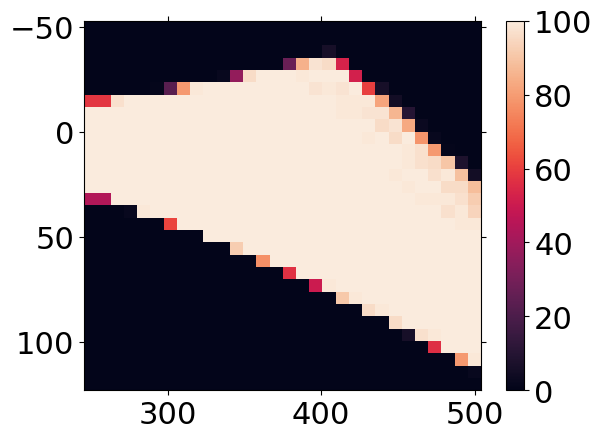

In [44]:
fig,ax = plt.subplots()
heatmap = ax.pcolormesh(VRFs,VDCs,DATA.T, cmap = 'rocket')
fig.colorbar(heatmap)
ax.invert_yaxis()

In [45]:
N_sim = 100

Vs = np.linspace(200, 500, 30)

Ns, Us, N_histories = zip(*Parallel(n_jobs=15, verbose=10)(delayed(simulate_signal)(V, r0, z0, Omega, mass, charge_number, N_sim, ts) for V in Vs))
Ns = np.array(Ns)
Us = np.array(Us)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=15)]: Done   5 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=15)]: Done   9 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  13 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  17 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  21 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=15)]: Done  25 out of  30 | elapsed:    0.0s remaining:    0.0s


NameError: name 'upper_mathieu_variable_shrink' is not defined

In [ ]:
np.savez('../Final simulations mz 415/CIT_edge_buffer_gas_10ms_50ns_100K_0.25mm', Vs=Vs, Us=Us, Ns=Ns, N_histories=N_histories, allow_pickle=True)

In [ ]:
load_file = np.load('CIT_edge_10ms_50ns_100K_0.25mm_2.npz')
Vs = load_file['Vs']
Us = load_file['Us']
Ns = load_file['Ns']

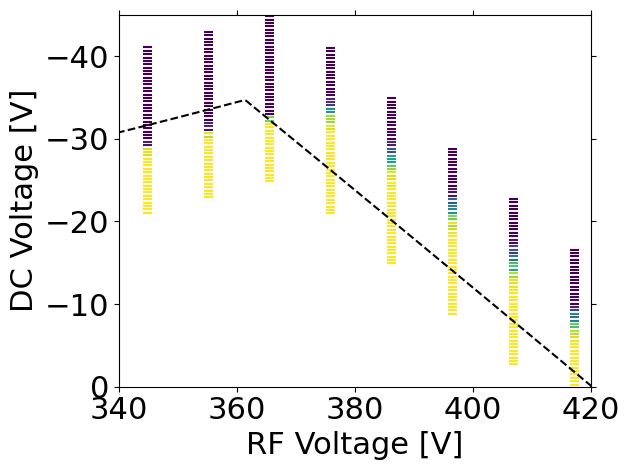

In [ ]:
for V, U, N in zip(Vs, Us, Ns):
    n = len(N)
    plt.scatter(V*np.ones(n), U, c=N, marker='_')
mass = 414
linspace_Vs = np.linspace(Vs[0], Vs[-1], 1000)
xi = np.sqrt(2.35e-4)
plt.plot(linspace_Vs, QIT_diagram(linspace_Vs, True,  mass, QIT_r0=xi, QIT_z0=0), 'k--')
plt.plot(linspace_Vs, QIT_diagram(linspace_Vs, False, mass, QIT_r0=xi, QIT_z0=0), 'k--')

plt.xlim(340, 420)
plt.ylim(0, -45)
plt.xlabel('RF Voltage [V]')
plt.ylabel('DC Voltage [V]')
plt.tight_layout()